# Sieć neuronowa

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, roc_curve, RocCurveDisplay, auc, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler

c:\Users\Lidia\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def metrics(y_true, y_pred):
    print('accuracy:', accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print('sensitivity:', recall_score(y_true, y_pred))
    print('specificity:', cm[0][0]/(cm[0][0]+cm[0][1]))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

In [3]:
def surface(classifier, xi, yi):
    minx, maxx = min(xi[:,0]), max(xi[:,0])
    miny, maxy = min(xi[:,1]), max(xi[:,1])
    x = np.linspace(minx, maxx, 1000)
    y = np.linspace(miny, maxy, 1000)

    X, Y = np.meshgrid(x,y)
    Z = []

    for i in range(len(X)):
        for j in range(len(Y)):
            Z.append(classifier.predict(np.array([X[i,j], Y[i,j]])).argmax(axis=0))

                    
    Z = np.reshape(Z, X.shape)
        
    plt.scatter(xi[yi==0,0], xi[yi==0,1], label='Klasa 0')
    plt.scatter(xi[yi==1,0], xi[yi==1,1], label='Klasa 1')
    plt.legend()
    plt.contourf(X, Y, Z, alpha=0.3)
    plt.show()

## Generowanie zbioru


In [4]:
x, y = make_blobs(random_state=254448, n_samples=2548, n_features=2, centers=6)

#0,1,2 -> 0
#3,4,5 -> 1
y[np.isin(y, [0,1,2])] = 0
y[np.isin(y, [3,4,5])] = 1


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=254448, stratify=y)

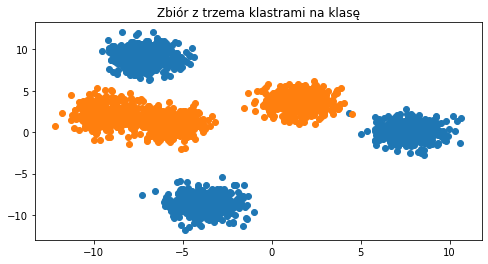

In [5]:
fig, ax1 = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(8)

ax1.scatter(x[y==0,0], x[y==0,1])
ax1.scatter(x[y==1,0], x[y==1,1])
ax1.set_title('Zbiór z trzema klastrami na klasę')
plt.show()

## Implementacja sieci neuronowej

In [19]:
class Layer:
    def forward(self, x):
        pass
    
    def backward(self, grad):
        pass
    
    def adjust(self):
        pass

def MSE(targets, predicted):
    return np.sum((targets - predicted) ** 2)

def MSE_derivative(targets, predicted):
    return 2 * (predicted - targets)

class Linear(Layer):
    def __init__(self, eta, input_size, output_size):
        self.eta = eta
        self.w = np.random.normal(0, 1, (input_size, output_size))
        self.b = np.zeros((output_size))
        
    def forward(self, x):
        self.x = x
        #print(x @ self.w + self.b)
        return x @ self.w + self.b
    
    def backward(self, grad):
        self.grad = grad
        #print(grad)
        return grad @ self.w.T
    
    def adjust(self):
        self.w -= self.eta * self.x.T @ self.grad
        self.b -= self.eta * np.sum(self.grad, axis=0)

class Activation(Layer):
    def __init__(self, activation_function):
        if activation_function == 'logistic':
            self.fun = lambda s: 1 / (1 + np.exp(-s))
            self.der = lambda s: self.fun(s) * (1 - self.fun(s))
        elif activation_function == 'ReLu':
            self.fun = lambda s: np.where(s > 0, s, 0)
            self.der = lambda s: np.where(s > 0, 1, 0)
        else:
            raise Exception('Nieprawidlowa funkcja aktywacji')    
            
    def forward(self, s):
        self.s = s
        return self.fun(s)
    
    def backward(self, grad):
        return self.der(self.s) * grad

def transform_array(input_array):
    unique_values = sorted(set(input_array))
    value_to_index = {value: idx for idx, value in enumerate(unique_values)}
    output_matrix = []
    for value in input_array:
        row = [0] * len(unique_values)
        row[value_to_index[value]] = 1
        output_matrix.append(row)
    return np.array(output_matrix)

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        self.outputs = inputs
        return inputs
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def adjust(self):
        for layer in self.layers:
            layer.adjust()
    
    def train(self, inputs, target, num_epoch=100, batch_size=64):
        target = transform_array(target)

        for epoch in range(num_epoch):
            for start in range(0, len(target), batch_size):
                end = start + batch_size
                
                batch_inputs = inputs[start:end]
                batch_target = target[start:end]
                
                result = self.forward(batch_inputs)
                error_der = MSE_derivative(batch_target, result)
                self.backward(error_der)
                self.adjust()
            if epoch%10==9:    
                mse = MSE(target, self.forward(inputs))
                print(f'Epoch {epoch + 1}/{num_epoch}, MSE: {mse}')

    def predict(self, x):
        return self.forward(x)

## Nauka na syntetycznym zbiorze wielomodowym

In [26]:
pierwsza = Linear(0.01, 2, 3)
druga = Activation('ReLu')
trzecia = Linear(0.01, 3, 2)
czwarta = Activation('logistic')
piata = Linear(0.01, 2, 2)
szosta = Activation('logistic')

siec = NeuralNetwork([pierwsza,druga,trzecia,czwarta,piata,szosta])

siec.train(x_train, y_train, batch_size=128) 

Epoch 10/100, MSE: 55.792810011943885
Epoch 20/100, MSE: 27.615271690685233
Epoch 30/100, MSE: 20.735945455995278
Epoch 40/100, MSE: 11.61377047728838
Epoch 50/100, MSE: 9.376447671887721
Epoch 60/100, MSE: 6.748983541545532
Epoch 70/100, MSE: 5.643042548998137
Epoch 80/100, MSE: 4.89121227332818
Epoch 90/100, MSE: 4.330576916010536
Epoch 100/100, MSE: 3.9497310006658237


In [27]:
accuracy_score(y_test, siec.predict(x_test).argmax(axis=1))

0.9921507064364207

accuracy: 0.9921507064364207
sensitivity: 0.9968553459119497
specificity: 0.987460815047022


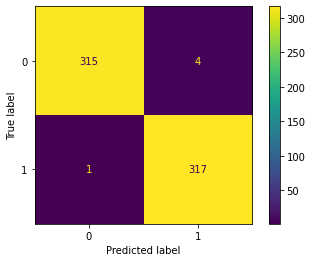

In [28]:
metrics(y_test, siec.predict(x_test).argmax(axis=1))

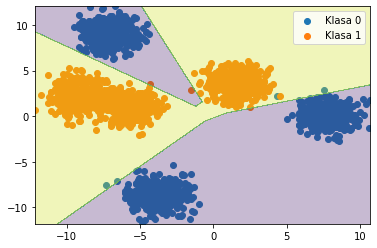

In [29]:
surface(siec, x, y)

## Trening sieci na zbiorze MNIST

In [11]:
(x_trainm, y_trainm), (x_testm, y_testm) = mnist.load_data()

scaler = MinMaxScaler()

In [12]:
x_trainm = np.array([i.flatten() for i in x_trainm])
x_testm = np.array([i.flatten() for i in x_testm])

x_trainm = scaler.fit_transform(x_trainm)
x_testm = scaler.transform(x_testm)

In [34]:
pierwsza = Linear(0.1, 784, 100)
druga = Activation('ReLu')
trzecia = Linear(0.1, 100, 10)
czwarta = Activation('logistic')
piata = Linear(0.1, 10, 10)
szosta = Activation('logistic')

siec_mnist = NeuralNetwork([pierwsza,druga,trzecia,czwarta,piata,szosta])

siec_mnist.train(x_trainm, y_trainm, batch_size=128, num_epoch=100) 

C:\Users\Lidia\AppData\Local\Temp\ipykernel_11192\3638883603.py:40: RuntimeWarning: overflow encountered in exp
  self.fun = lambda s: 1 / (1 + np.exp(-s))


Epoch 10/100, MSE: 11415.426516922225
Epoch 20/100, MSE: 11100.059144062272
Epoch 30/100, MSE: 10267.974089285402
Epoch 40/100, MSE: 9261.60085869767
Epoch 50/100, MSE: 8129.256805264145
Epoch 60/100, MSE: 9033.670993731577
Epoch 70/100, MSE: 7143.5469149638475
Epoch 80/100, MSE: 10174.331351063773
Epoch 90/100, MSE: 8343.92851074924
Epoch 100/100, MSE: 8147.741558072756


In [35]:
accuracy_score(y_testm, siec_mnist.predict(x_testm).argmax(axis=1))

C:\Users\Lidia\AppData\Local\Temp\ipykernel_11192\3638883603.py:40: RuntimeWarning: overflow encountered in exp
  self.fun = lambda s: 1 / (1 + np.exp(-s))


0.9134

C:\Users\Lidia\AppData\Local\Temp\ipykernel_11192\3638883603.py:40: RuntimeWarning: overflow encountered in exp
  self.fun = lambda s: 1 / (1 + np.exp(-s))


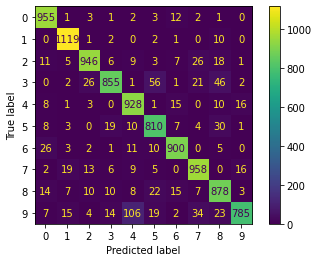

In [36]:
cm = confusion_matrix(y_testm, siec_mnist.predict(x_testm).argmax(axis=1))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
print('')